In [14]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy

# Activating Virtual Environment (MAC): source venv/bin/activate
# Deactivating: deactivate
"""
import os

import scanpy as sc
import pandas as pd
import harmonypy as hm
import celltypist

# Define Filenames
H5_FILENAME = 'GSE178341_crc10x_full_c295v4_submit.h5'
H5AD_FILENAME = H5_FILENAME.replace('.h5', '.h5ad')


In [15]:
if os.path.exists(H5_FILENAME) and not os.path.exists(H5AD_FILENAME):
    # Convert h5 to h5AD (Roughly 10 minutes)
    adata = sc.read_10x_h5(H5_FILENAME)
    adata.write_h5ad(H5AD_FILENAME)

In [16]:
# Read h5AD File 
adata = sc.read_h5ad("GSE178341_crc10x_full_c295v4_submit.h5ad")

In [17]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

                                        total_counts  n_genes_by_counts  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT       15093.0               2953   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT        1156.0                407   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG       50243.0               6522   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT       16254.0               3363   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC       42007.0               6151   

                                        pct_counts_mt  
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT       7.626052  
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT      35.207612  
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG      11.203551  
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT      10.852713  
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC      11.926584  


In [18]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

Remaining cells after filtering: 95293


In [19]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [20]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [21]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

Number of highly variable genes: 2237


In [22]:
# Save the Processed Data
adata.write("GSE178341_QC.h5ad")

In [23]:
adata = sc.read_h5ad("GSE178341_QC.h5ad")

In [24]:
# Read metadata
metadata = pd.read_csv("GSE178341_crc10x_full_c295v4_submit_metatables.csv")
print(metadata.head())

                                   cellID SPECIMEN_TYPE SOURCE_HOSPITAL  \
0  C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT             T             MGH   
1  C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT             T             MGH   
2  C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG             T             MGH   
3  C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT             T             MGH   
4  C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC             T             MGH   

  TISSUE_PROCESSING_TEAM PROCESSING_TYPE SINGLECELL_TYPE PatientTypeID  \
0                Hacohen        unsorted          SC3Pv2        C103_T   
1                Hacohen        unsorted          SC3Pv2        C103_T   
2                Hacohen        unsorted          SC3Pv2        C103_T   
3                Hacohen        unsorted          SC3Pv2        C103_T   
4                Hacohen        unsorted          SC3Pv2        C103_T   

  HistologicTypeSimple    MMR_IHC MMRStatus  ... NodeStatus_detailed  \
0       Adenocarcinoma  preserve

In [25]:
if 'MMRStatus' not in adata.obs.columns:
    # Import the MMR Statuses (merge in the metadata by matching the cell IDs)
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(metadata[['cellID', 'MMRStatus']], left_on='index', right_on='cellID', how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=['cellID'], inplace=True)

In [26]:
# Check counts of MMRd vs. MMRp
print(adata.obs["MMRStatus"].value_counts())  

MMRStatus
MMRp    37076
MMRd    29365
Name: count, dtype: int64


In [27]:
"""
Formatting for Batch Correction
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0]     # Patient IDs
adata.obs["region"] = obs_names.str[1]    # Sample Regions
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample
print(adata.obs["region"].value_counts())

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64
region
T     61539
N     28852
TA     2960
TB     1942
Name: count, dtype: int64


In [28]:
# Separate dataset into MMRp, MMRd, and isolate tumor cells
adata_MMRp = adata[adata.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata[adata.obs['MMRStatus'] == 'MMRd'].copy()
adata_tumor = adata[adata.obs['region'] == 'T'].copy()

In [29]:
# Perform PCA and clustering 

# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

# For Tumor Cells
sc.tl.pca(adata_tumor, svd_solver='arpack')
sc.pp.neighbors(adata_tumor, n_neighbors=10, n_pcs=40)

/Users/dylansnyder/BENG 204 CRC Python/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Run Harmony for batch correction (8.5 minutes)
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T
adata_tumor.obsm["X_pca_harmony"] = hm.run_harmony(adata_tumor.obsm["X_pca"], adata_tumor.obs, 'batch').Z_corr.T

2025-03-16 15:12:06,389 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-16 15:12:18,290 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-03-16 15:12:18,486 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-03-16 15:12:34,314 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-03-16 15:12:50,205 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-03-16 15:13:03,826 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-03-16 15:13:11,816 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-03-16 15:13:19,562 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations
2025-03-16 15:13:19,618 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-03-16 15:13:28,933 - harmonypy - INFO - sklearn.KMeans initializatio

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


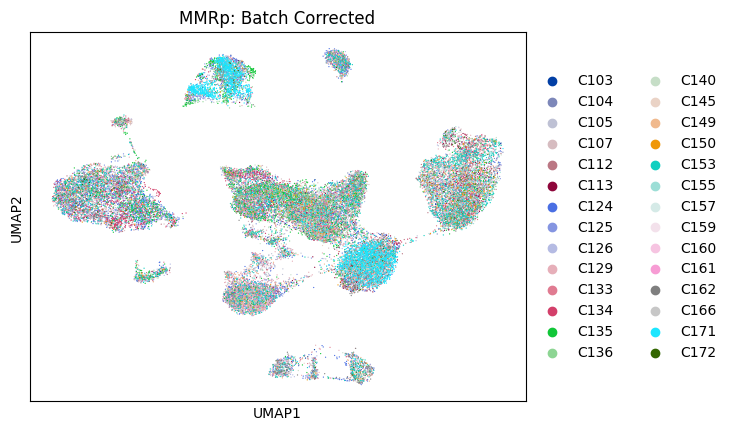

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


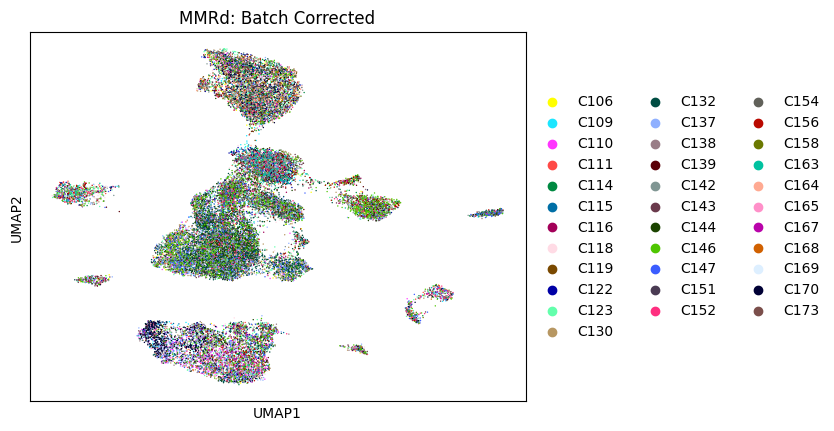

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


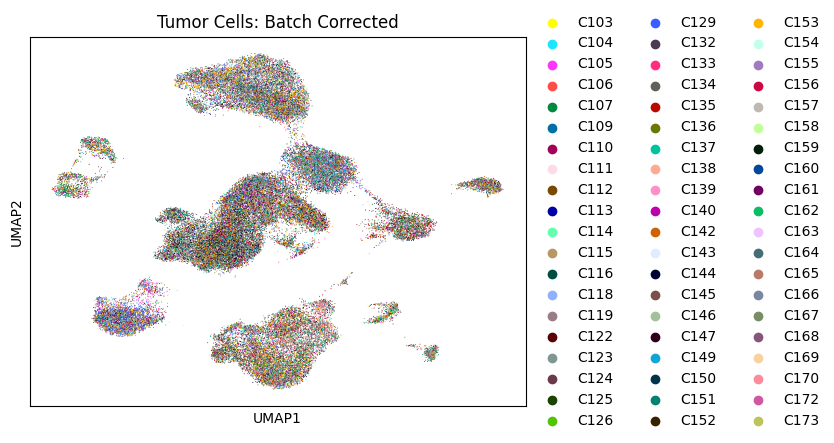

In [31]:
# Update neighbors & recompute UMAP (3.5 minutes)
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

sc.pp.neighbors(adata_tumor, use_rep="X_pca_harmony")
sc.tl.umap(adata_tumor)
sc.pl.umap(adata_tumor, color="batch", title="Tumor Cells: Batch Corrected")

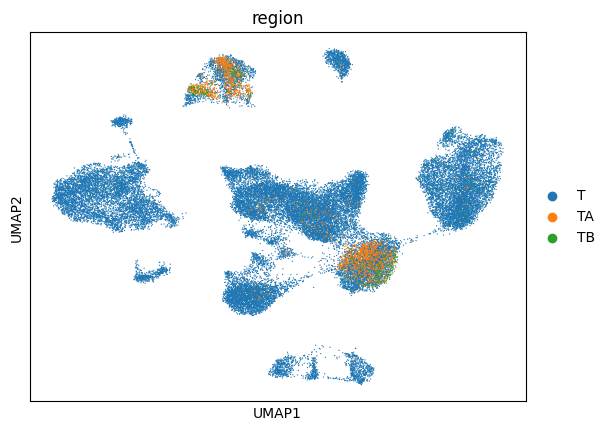

In [32]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])

In [33]:
# Leiden clustering 
sc.tl.leiden(adata_MMRp, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_MMRd, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_tumor, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

In [36]:
# DE Analysis between Normal Tissue and MMRd/MMRp Environments

import pandas as pd
import numpy as np

# Separating Groups 
adata_normal = adata[adata.obs['region'] == 'N'].copy()
adata_mmrd = adata[adata.obs['MMRStatus'] == 'MMRd'].copy()
adata_mmrp = adata[adata.obs['MMRStatus'] == 'MMRp'].copy()

# Combining Groups for DE Analysis
adata_mmrp_normal = adata[adata.obs['MMRStatus'].isin(['MMRp']) | (adata.obs['region'] == 'N')].copy()
adata_mmrd_normal = adata[adata.obs['MMRStatus'].isin(['MMRd']) | (adata.obs['region'] == 'N')].copy()

# Running DE Analysis (MMrp v.s. Normal)
sc.tl.rank_genes_groups(adata_mmrp_normal, groupby="MMRStatus", method="wilcoxon")
de_mmrp = sc.get.rank_genes_groups_df(adata_mmrp_normal, group="MMRp")

# Running DE Analysis (MMrd v.s. Normal)
sc.tl.rank_genes_groups(adata_mmrd_normal, groupby="MMRStatus", method="wilcoxon")
de_mmrd = sc.get.rank_genes_groups_df(adata_mmrd_normal, group="MMRd")

# Filtering Results

de_mmrp["pvals"].replace(0, 1e-315, inplace=True)  # Avoid log(0) errors
de_mmrp["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

de_mmrd["pvals"].replace(0, 1e-315, inplace=True)  # Avoid log(0) errors
de_mmrd["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_mmrp.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)
de_mmrd.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save results
de_mmrp.to_csv("MMRp_vs_Normal.csv", index=False)
de_mmrd.to_csv("MMRd_vs_Normal.csv", index=False)

# Show top genes
print(de_mmrp.head(10))
print(de_mmrd.head(10))

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical
... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


      names     scores  logfoldchanges          pvals  pvals_adj
0      SAT1  63.270752        1.534032  1.000000e-315        0.0
1       LYZ  48.070671        3.154737  1.000000e-315        0.0
2    IFITM3  42.381805        1.856592  1.000000e-315        0.0
3   HLA-DRA  41.197643        1.440663  1.000000e-315        0.0
4  HLA-DRB1  40.457451        1.607268  1.000000e-315        0.0
5    IFITM2  39.764709        1.337947  1.000000e-315        0.0
6   TNFAIP3  39.712948        1.935527  1.000000e-315        0.0
7  HLA-DPB1  38.732025        1.382463  1.000000e-315        0.0
8    GPR183  38.545078        1.570157  1.000000e-315        0.0
9      CST3  38.249104        1.353363  1.000000e-315        0.0
      names     scores  logfoldchanges          pvals  pvals_adj
0      CCL5  62.399803        3.517860  1.000000e-315        0.0
1    IFITM2  61.482754        2.013289  1.000000e-315        0.0
2      GZMB  61.288433        4.959460  1.000000e-315        0.0
3      CCL4  59.445133   

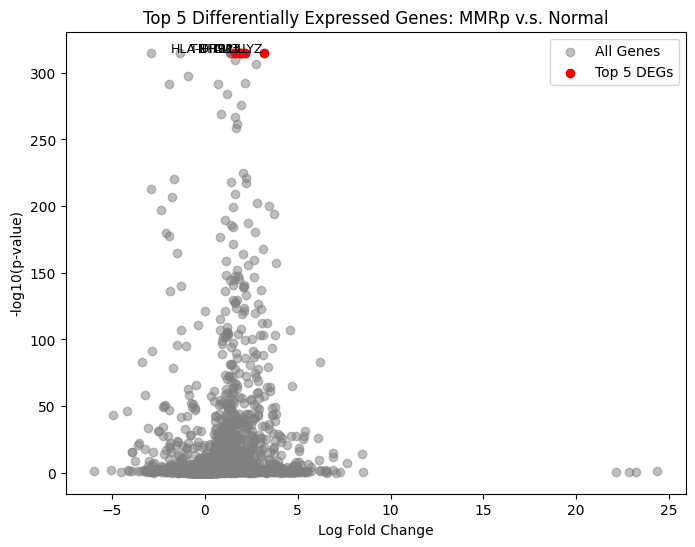

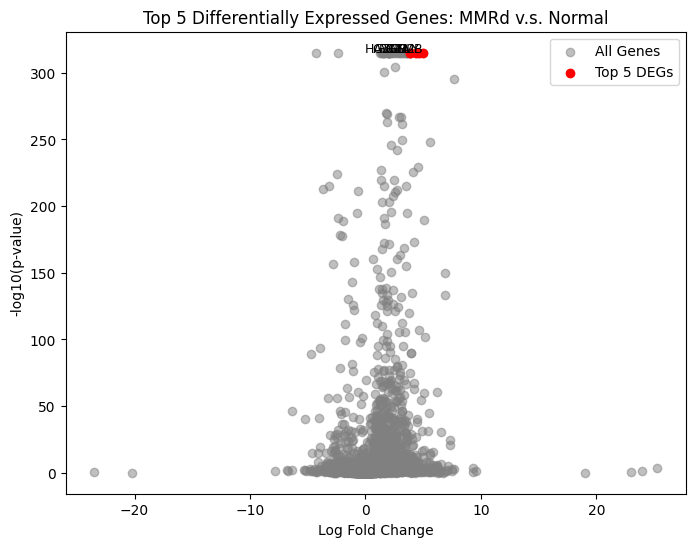

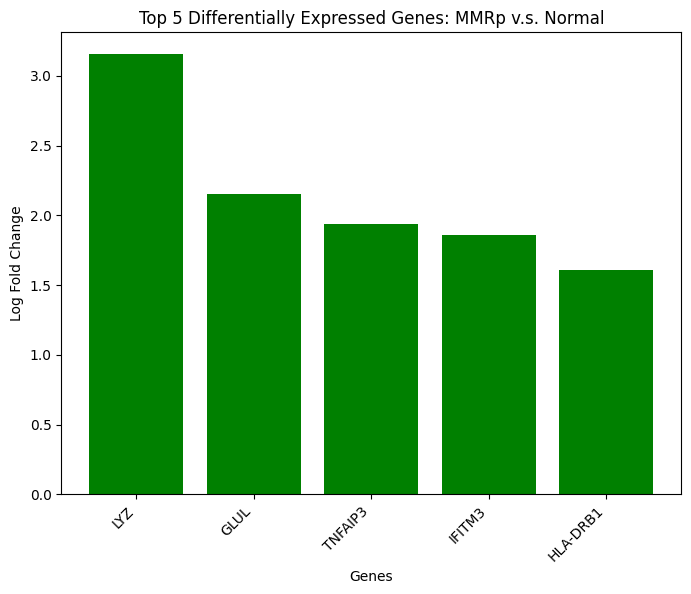

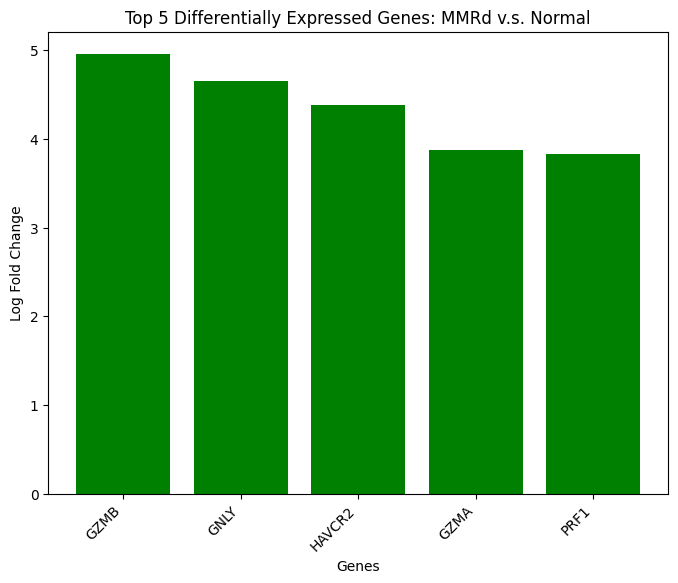

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the DE results by p-value and logFC
de_mmrp_sorted = de_mmrp.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])
de_mmrd_sorted = de_mmrd.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])

# Select top 5 genes
top_5_genes_mmrp = de_mmrp_sorted.head(5)
top_5_genes_mmrd = de_mmrd_sorted.head(5)

# Volcano Plot for MMRp v.s. Normal
plt.figure(figsize=(8, 6))
plt.scatter(de_mmrp["logfoldchanges"], -np.log10(de_mmrp["pvals"]), alpha=0.5, color='grey', label="All Genes")
plt.scatter(top_5_genes_mmrp["logfoldchanges"], -np.log10(top_5_genes_mmrp["pvals"]), color='red', label="Top 5 DEGs")

# Label the top 5 genes
for i, row in top_5_genes_mmrp.iterrows():
    plt.text(row["logfoldchanges"], -np.log10(row["pvals"]), row["names"], fontsize=9, ha="right")

plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Top 5 Differentially Expressed Genes: MMRp v.s. Normal")
plt.legend()
plt.show()

# Volcano Plot for MMRd v.s. Normal
plt.figure(figsize=(8, 6))
plt.scatter(de_mmrd["logfoldchanges"], -np.log10(de_mmrd["pvals"]), alpha=0.5, color='grey', label="All Genes")
plt.scatter(top_5_genes_mmrd["logfoldchanges"], -np.log10(top_5_genes_mmrd["pvals"]), color='red', label="Top 5 DEGs")

# Label the top 5 genes
for i, row in top_5_genes_mmrd.iterrows():
    plt.text(row["logfoldchanges"], -np.log10(row["pvals"]), row["names"], fontsize=9, ha="right")

plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Top 5 Differentially Expressed Genes: MMRd v.s. Normal")
plt.legend()
plt.show()

# Bar Plot for Top 5 DEGs in MMRp
plt.figure(figsize=(8, 6))
plt.bar(top_5_genes_mmrp["names"], top_5_genes_mmrp["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Change")
plt.title("Top 5 Differentially Expressed Genes: MMRp v.s. Normal")
plt.xticks(rotation=45, ha="right")
plt.show()

# Bar Plot for Top 5 DEGs in MMRd
plt.figure(figsize=(8, 6))
plt.bar(top_5_genes_mmrd["names"], top_5_genes_mmrd["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Change")
plt.title("Top 5 Differentially Expressed Genes: MMRd v.s. Normal")
plt.xticks(rotation=45, ha="right")
plt.show()

In [44]:
# DE Analysis for MMRd v.s. MMRp

import scanpy as sc
import pandas as pd
import numpy as np

# Subset the data to only MMRD and MMRP cells
adata_sub = adata[adata.obs['MMRStatus'].isin(['MMRp', 'MMRd'])].copy()

# Perform DE analysis 
sc.tl.rank_genes_groups(adata_sub, groupby="MMRStatus", method="wilcoxon")

# Extract DE results for MMRD vs MMRP
de_results = sc.get.rank_genes_groups_df(adata_sub, group="MMRd")

# Handle extreme values safely
de_results["pvals"].replace(0, 1e-300, inplace=True)  # Avoid log(0) errors
de_results["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 (neutral effect) & p-values with 1 (not significant)
de_results.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save results
de_results.to_csv("MMRD_vs_MMRP_DEGs.csv", index=False)

# Show top genes
print(de_results.head(10))

# It is acceptable to have p-values close to zero as this is a large and high throughput dataset.

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical


    names     scores  logfoldchanges          pvals      pvals_adj
0    MT2A  52.256943        1.375977  1.000000e-300   0.000000e+00
1    CCL5  44.651451        1.872918  1.000000e-300   0.000000e+00
2    GZMB  43.182892        2.084113  1.000000e-300   0.000000e+00
3    GZMA  41.995499        1.913632  1.000000e-300   0.000000e+00
4    CCL4  39.764549        1.579251  1.000000e-300   0.000000e+00
5    NKG7  34.843288        1.526161  5.380654e-266  2.006087e-263
6    GNLY  32.978855        2.067555  1.632649e-238  5.217480e-236
7  CXCL13  30.376179        2.658653  1.133780e-202  3.170333e-200
8   KLRD1  30.329231        1.960532  4.721102e-202  1.173456e-199
9    MT1E  29.355377        1.494465  2.040225e-189  4.563982e-187


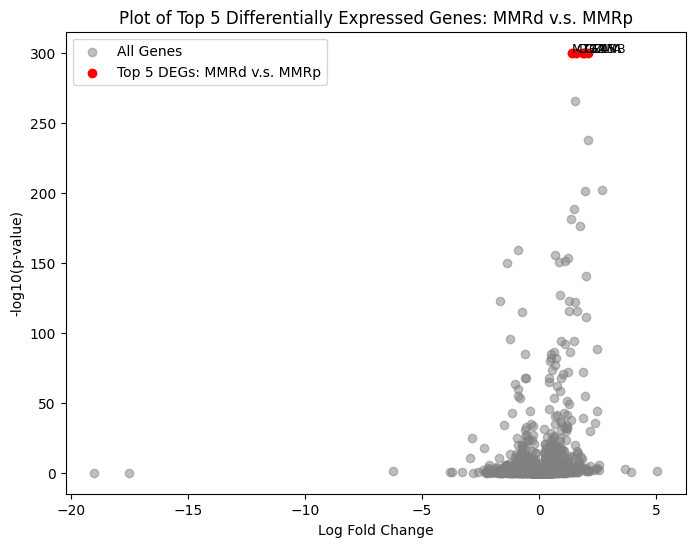

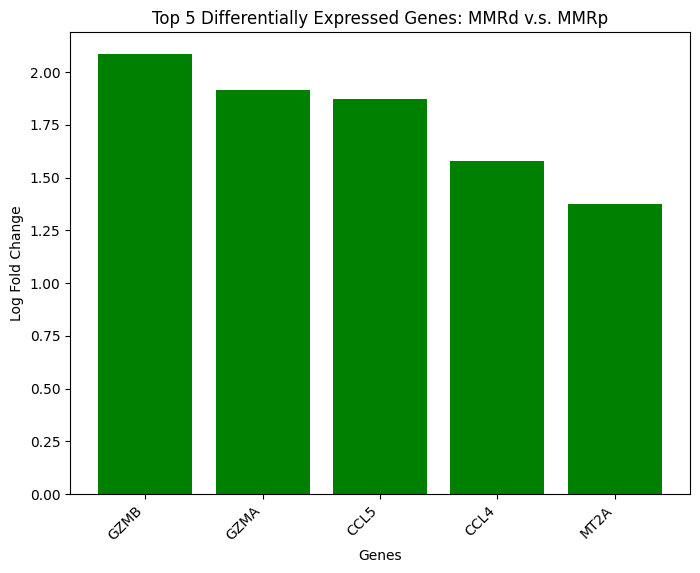

In [59]:
# Plot Creation For DE for MMRd v.s. MMRp

import matplotlib.pyplot as plt

# Sort the DE results by p-value and logFC
de_results_sorted = de_results.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])

# Select top 5 genes
top_5_genes = de_results_sorted.head(5)

# Create a volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(de_results["logfoldchanges"], -np.log10(de_results["pvals"]), alpha=0.5, color='grey', label="All Genes")

# Highlight top 5 DEGs
plt.scatter(top_5_genes["logfoldchanges"], -np.log10(top_5_genes["pvals"]), color='red', label="Top 5 DEGs: MMRd v.s. MMRp")

# Label the top 5 genes
for i, row in top_5_genes.iterrows():
    plt.text(row["logfoldchanges"], -np.log10(row["pvals"]), row["names"], fontsize=9)

plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Plot of Top 5 Differentially Expressed Genes: MMRd v.s. MMRp")
plt.legend()
plt.show()

# Create a bar plot of top 5 DEGs
top_5_genes = de_results_sorted.head(5)

plt.figure(figsize=(8, 6))
plt.bar(top_5_genes["names"], top_5_genes["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Change")
plt.title("Top 5 Differentially Expressed Genes: MMRd v.s. MMRp")
plt.xticks(rotation=45, ha="right")  
plt.show()

In [46]:
# Creating Ranked List of Differential Expression for GSEA

import numpy as np

# Set a safe lower bound for p-values to avoid numerical instability
min_pval = 1e-50  

# Replace extremely small p-values with min_pval
de_results["safe_pval"] = de_results["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results["rank"] = de_results["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
de_results["rank"].fillna(0, inplace=True)

# Save ranked list
de_results[["names", "rank"]].to_csv("gsea_ranked_genes.rnk", sep="\t", index=False, header=False)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 34 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'R', 'S', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'v']
Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 23, 25, 26, 27, 36, 38, 40, 42, 43, 53, 54, 68, 70, 71, 72, 73, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 89]
Closed glyph list over 'GSUB': 37 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'R', 'S', 'a', 'c', 'd', 'e', 'eight', 'f', 'fi', 'four', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'uniFB00', 'uniFB03', 'v']
Glyph IDs:   [0, 1, 2, 3, 16, 20, 21, 23, 25, 26, 27, 36, 38, 40, 42, 43, 53, 54, 68, 70, 71, 72, 73, 75, 7

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name                                               Term        ES  \
0  prerank  Creation of C4 and C2 activators Homo sapiens ... -0.960685   
1  prerank  Classical antibody-mediated complement activat... -0.961017   
2  prerank  Initial triggering of complement Homo sapiens ... -0.914751   
3  prerank       Complement cascade Homo sapiens R-HSA-166658 -0.894059   
4  prerank         Signaling by Wnt Homo sapiens R-HSA-195721  -0.87387   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0  -1.69362       0.0  0.010858      0.008   4/25  0.31%   
1 -1.662383       0.0  0.015744      0.015   4/23  0.31%   
2   -1.6494       0.0   0.01701      0.022   4/28  0.31%   
3 -1.638904       0.0  0.019815      0.032   4/34  0.31%   
4 -1.519882  0.013937  0.247119      0.409  10/24  9.66%   

                                          Lead_ge

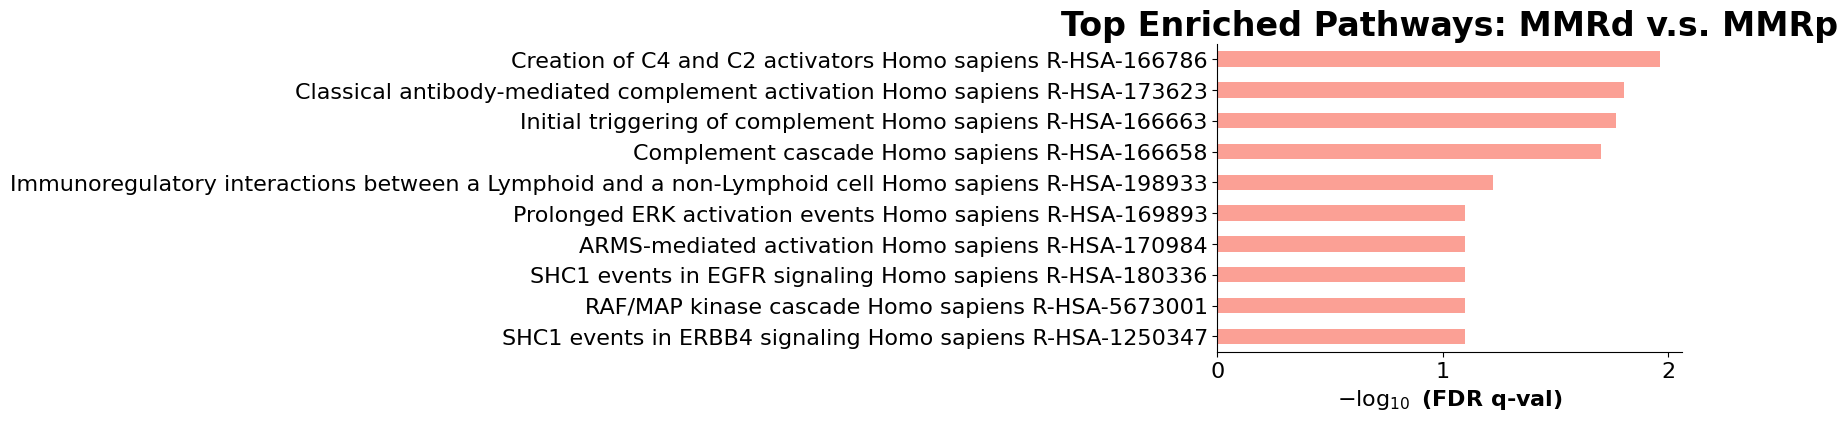

In [47]:
# Gene Set Enrichment Analysis Between MMRd and MMRp

import gseapy as gp
import matplotlib.pyplot as plt

gsea_results = gp.prerank(
    rnk="gsea_ranked_genes.rnk",
    gene_sets="Reactome_2016",  
    outdir="GSEA_results",
    seed=123,
    min_size=10,
    max_size=15000
)

print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())

# View the results
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways: MMRd v.s. MMRp",
    figsize=(6, 4),
    column="FDR q-val",
    cutoff=0.5
)
plt.show()

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name                 Term        ES       NES NOM p-val FDR q-val  \
0  prerank            RSRFC4_Q2 -0.883345 -1.604122  0.010239       1.0   
1  prerank               CDP_02 -0.948713 -1.601861       0.0  0.605115   
2  prerank              SOX5_01 -0.829035 -1.600542  0.013514  0.412902   
3  prerank          COUP_DR1_Q6 -0.863084 -1.598943  0.007547  0.324804   
4  prerank  TAAWWATAG_RSRFC4_Q2 -0.899214  -1.58296  0.009434  0.366628   

  FWER p-val Tag % Gene %                                         Lead_genes  
0      0.406  2/26  3.98%                                         TNNC2;TPM2  
1      0.418  2/15  0.80%                                        TCF4;MARCKS  
2      0.426  3/37  3.53%                                    ID1;TCF4;BCL11A  
3      0.437  9/31  7.29%  FABP1;ID1;INSR;CXCL14;HMGCS2;TPM2;SLC26A3;BCAM...  
4      0.543  2

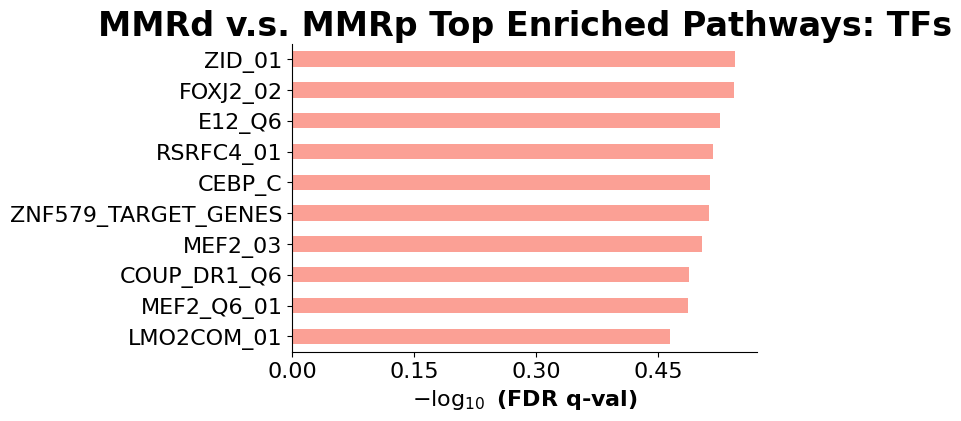

In [51]:
# TF Associated with MMRd v.s. MMRp

import gseapy as gp
import matplotlib.pyplot as plt

gsea_results = gp.prerank(
    rnk="gsea_ranked_genes.rnk",
    gene_sets="c3.tft.v2024.1.Hs.symbols.gmt",  
    outdir="gsea_tfresults",
    permutation_num=1000,
    seed=42,
)

print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())

# View the results
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="MMRd v.s. MMRp Top Enriched Pathways: TFs",
    figsize=(6, 4),
    column="FDR q-val",  
    cutoff=0.5
)
plt.show()

In [52]:
# Preparing Differential Expression Analysis Between Tumor and Tumor Adjacent Normal

adata_normal = adata[adata.obs['region'] == 'N'].copy() # Subsetting Tumor Adjacent Normal Cells
adata_tumor = adata[adata.obs['region'] == 'T'].copy() # Subsetting Tumor Cells

print(adata.obs["region"].value_counts())

region
T     61539
N     28852
TA     2960
TB     1942
Name: count, dtype: int64


In [53]:
# Differential Expression Analysis Between Normal and Tumor Tissue Sampling Regions

# Combine the normal and tumor data
adata_combo = adata_normal.concatenate(adata_tumor, batch_key="group", batch_categories=["Normal", "Tumor"])

# Add a new column to indicate the group (Normal vs Tumor)
adata_combo.obs['group'] = ['Normal'] * len(adata_normal) + ['Tumor'] * len(adata_tumor)

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_combo, groupby="group", method="wilcoxon")

# Extract DE results into a dataframe
de_results_normalt = sc.get.rank_genes_groups_df(adata_combo, group="Tumor")

# Handle extreme values safely
de_results_normalt["pvals"].replace(0, 1e-315, inplace=True)  # Avoid log(0) errors
de_results_normalt["logfoldchanges"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs in logFC with 0 & p-values with 1 
de_results_normalt.fillna({"logfoldchanges": 0, "pvals": 1, "pvals_adj": 1}, inplace=True)

# Save results to CSV
de_results_normalt.to_csv("Normal_vs_Tumor_DEGs.csv", index=False)

# Show top differentially expressed genes
print(de_results_normalt.head(15))

... storing 'MMRStatus' as categorical
... storing 'batch' as categorical
... storing 'region' as categorical
... storing 'group' as categorical


       names     scores  logfoldchanges          pvals  pvals_adj
0       SAT1  69.716988        1.603837  1.000000e-315        0.0
1     IFITM2  58.532425        1.713394  1.000000e-315        0.0
2   HLA-DRB1  57.451248        1.901219  1.000000e-315        0.0
3    HLA-DRA  56.911594        1.718589  1.000000e-315        0.0
4   HLA-DPB1  52.565212        1.564734  1.000000e-315        0.0
5        CD2  51.782337        2.352433  1.000000e-315        0.0
6        LYZ  51.408615        3.165063  1.000000e-315        0.0
7     IFITM3  50.146790        1.966421  1.000000e-315        0.0
8        TXN  49.224968        1.124350  1.000000e-315        0.0
9       CTSD  48.066059        1.877886  1.000000e-315        0.0
10     ANXA1  47.643257        1.830352  1.000000e-315        0.0
11      GLUL  46.838074        2.388913  1.000000e-315        0.0
12    SAMSN1  46.655228        2.062405  1.000000e-315        0.0
13      CCL5  45.527538        2.553822  1.000000e-315        0.0
14      GZ

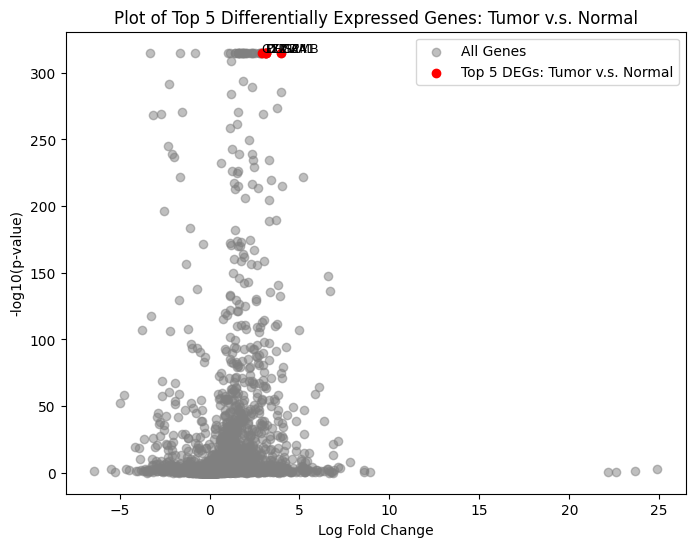

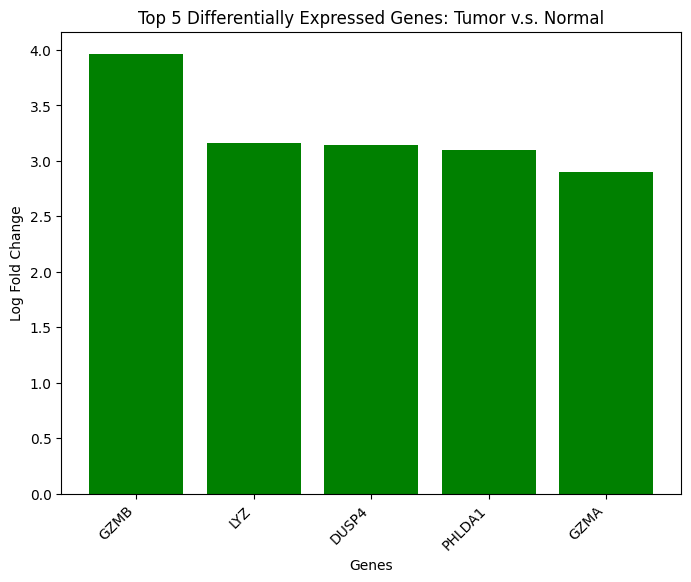

In [54]:
# Plot Creation for Tumor v.s. Normal

import matplotlib.pyplot as plt

# Sort the DE results by p-value and logFC
de_results_sortednt = de_results_normalt.sort_values(by=['pvals', 'logfoldchanges'], ascending=[True, False])

# Select top 5 genes
top_5_genesnt = de_results_sortednt.head(5)

# Create a volcano plot
plt.figure(figsize=(8, 6))
plt.scatter(de_results_normalt["logfoldchanges"], -np.log10(de_results_normalt["pvals"]), alpha=0.5, color='grey', label="All Genes")

# Highlight top 5 DEGs
plt.scatter(top_5_genesnt["logfoldchanges"], -np.log10(top_5_genesnt["pvals"]), color='red', label="Top 5 DEGs: Tumor v.s. Normal")

# Label the top 5 genes
for i, row in top_5_genesnt.iterrows():
    plt.text(row["logfoldchanges"], -np.log10(row["pvals"]), row["names"], fontsize=9)

plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Plot of Top 5 Differentially Expressed Genes: Tumor v.s. Normal")
plt.legend()
plt.show()

# Create a bar plot of top 5 DEGs
top_5_genes = de_results_sortednt.head(5)

plt.figure(figsize=(8, 6))
plt.bar(top_5_genes["names"], top_5_genes["logfoldchanges"], color='green')
plt.xlabel("Genes")
plt.ylabel("Log Fold Change")
plt.title("Top 5 Differentially Expressed Genes: Tumor v.s. Normal")
plt.xticks(rotation=45, ha="right")  
plt.show()

In [55]:
# Ranking Differential Expression for GSEA 

import numpy as np

# Avoiding avoid numerical instability
min_pval = 1e-50  

# Replace extremely small p-values with min_pval
de_results_normalt["safe_pval"] = de_results_normalt["pvals"].clip(lower=min_pval)

# Compute ranking score (logFC * -log10(p-value))
de_results_normalt["rank"] = de_results_normalt["logfoldchanges"] * -np.log10(de_results["safe_pval"])

# Handle infinities or NaNs
de_results_normalt["rank"].replace([np.inf, -np.inf], np.nan, inplace=True)
de_results_normalt["rank"].fillna(0, inplace=True)

# Save ranked list
de_results_normalt[["names", "rank"]].to_csv("gsea_ranked_genes_normalt.rnk", sep="\t", index=False, header=False)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 34 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'P', 'R', 'S', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two']
Glyph IDs:   [0, 1, 2, 3, 16, 21, 22, 24, 25, 26, 36, 40, 42, 43, 51, 53, 54, 68, 69, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87]
Closed glyph list over 'GSUB': 34 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'P', 'R', 'S', 'a', 'b', 'c', 'd', 'e', 'five', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two']
Glyph IDs:   [0, 1, 2, 3, 16, 21, 22, 24, 25, 26, 36, 40, 42, 43, 51, 53, 54, 68, 69, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 8

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name                                               Term        ES  \
0  prerank  FCERI mediated NF-kB activation Homo sapiens R... -0.922841   
1  prerank  Scavenging of heme from plasma Homo sapiens R-... -0.916185   
2  prerank  Antigen activates B Cell Receptor (BCR) leadin... -0.923723   
3  prerank  Binding and Uptake of Ligands by Scavenger Rec... -0.793829   
4  prerank    Biological oxidations Homo sapiens R-HSA-211859 -0.751626   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0 -1.547588  0.003676  0.426454      0.196  11/17  3.31%   
1  -1.52247  0.014493  0.347563      0.314  11/17  3.31%   
2 -1.481505  0.015873  0.480535      0.568   6/12  2.73%   
3 -1.467365  0.051793  0.438175      0.645  15/31  6.93%   
4   -1.4614  0.049451  0.383287      0.683   8/40  8.00%   

                                          Lead_ge

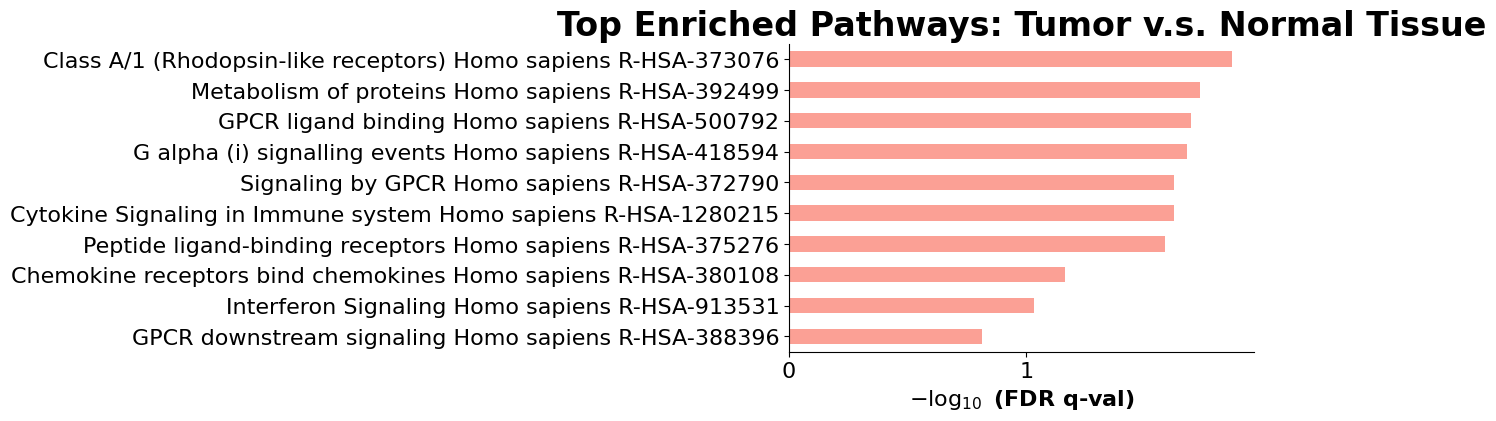

In [56]:
# Gene Set Enrichment Between Normal Tissue and Tumor Tissue

import gseapy as gp

gsea_results = gp.prerank(
    rnk="gsea_ranked_genes_normalt.rnk",
    gene_sets="Reactome_2016",  
    outdir="GSEA_results",
    seed=123,
    min_size=10,
    max_size=15000
)

print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Top Enriched Pathways: Tumor v.s. Normal Tissue",
    figsize=(6, 4),
    column="FDR q-val", 
    cutoff=0.5
)
plt.show()

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 26 glyphs before
Glyph names: ['.notdef', '.null', 'E', 'F', 'G', 'H', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 't', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 40, 41, 42, 43, 49, 53, 54, 66, 68, 70, 71, 72, 75, 76, 78, 80, 81, 82, 85, 87]
Closed glyph list over 'GSUB': 26 glyphs after
Glyph names: ['.notdef', '.null', 'E', 'F', 'G', 'H', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'r', 'space', 't', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 40, 41, 42, 43, 49, 53, 54, 66, 68, 70, 71, 72, 75, 76, 78, 80, 81, 82, 85, 87]
Closing glyph list over 'glyf': 26 glyphs before
Glyph names: ['.notdef', '.null', 'E', 'F', 'G', 'H', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'h', 'i', '

Index(['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val',
       'Tag %', 'Gene %', 'Lead_genes'],
      dtype='object')
      Name         Term        ES       NES NOM p-val FDR q-val FWER p-val  \
0  prerank      HNF1_01 -0.816232 -1.617096       0.0   0.23589      0.301   
1  prerank  COUP_DR1_Q6 -0.866013 -1.541744  0.008368  0.507333      0.735   
2  prerank  PPAR_DR1_Q2 -0.800541 -1.501033  0.022624  0.639198      0.903   
3  prerank       DR1_Q3 -0.811464  -1.44475  0.041322  0.919576      0.983   
4  prerank  HNF4_DR1_Q3 -0.744142  -1.43958  0.071429   0.77223      0.987   

  Tag % Gene %                                        Lead_genes  
0  7/55  7.51%  GUCA2A;GUCA2B;SLC26A3;EFEMP1;SLC4A4;UGT2A3;NR1H4  
1  5/31  4.20%                  FABP1;SLC26A3;INSR;HMGCS2;EFEMP1  
2  4/38  4.20%                          FABP1;INSR;HMGCS2;EFEMP1  
3  5/31  9.57%                     INSR;HMGCS2;EFEMP1;FBLN1;BCAM  
4  3/42  4.20%                                 FABP1;INSR

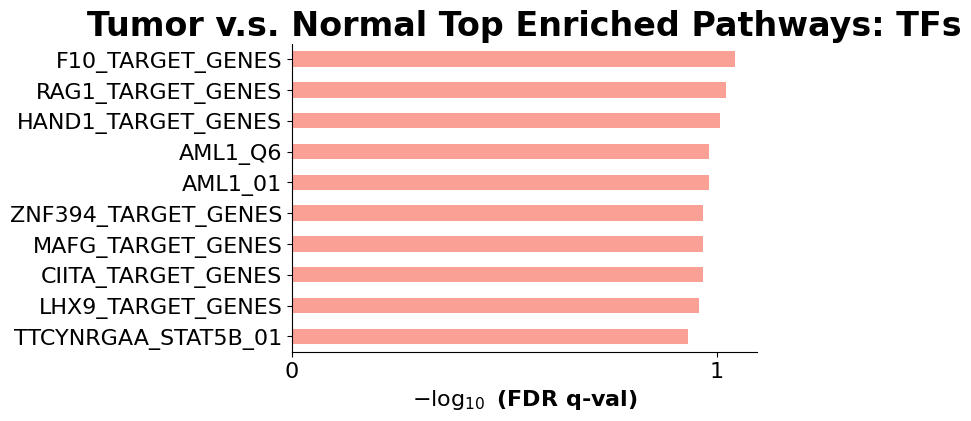

In [57]:
# TF Associated with Tumor v.s. Normal Tissue

import matplotlib.pyplot as plt
import gseapy as gp

gsea_results = gp.prerank(
    rnk="gsea_ranked_genes_normalt.rnk",
    gene_sets="c3.tft.v2024.1.Hs.symbols.gmt",  
    outdir="gsea_tfresults",
    permutation_num=1000,
    seed=42,
)

print(gsea_results.res2d.columns)
print(gsea_results.res2d.head())

# View the results
print(gsea_results.res2d.head())

# Plot the enrichment results
gp.barplot(
    gsea_results.res2d,
    title="Tumor v.s. Normal Top Enriched Pathways: TFs",
    figsize=(6, 4),
    column="FDR q-val", 
    cutoff=0.5
)
plt.show()

In [58]:
# STOP CODE
import sys
sys.exit("STOP!")

SystemExit: STOP!